<a href="https://colab.research.google.com/github/hbaflast/fasttext-sentiment-analysis/blob/master/fasttext_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fastText Sentiment Analysis

## Import

In [1]:
# Switch to tf2 (Colab run tensorflow 1.X by default for the moment)
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import os
import io
import codecs
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

In [0]:
plt.rcParams["figure.figsize"] = (16, 9)

## Load data

### Kaggle credentials

In [0]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME'] = "hbaflast"
os.environ['KAGGLE_KEY'] = "e1fbb7c60a14101f3d3531500537c6d0"

In [10]:
!kaggle datasets download hbaflast/french-twitter-sentiment-analysis

 68% 33.0M/48.3M [00:01<00:01, 15.6MB/s]
100% 48.3M/48.3M [00:01<00:00, 41.7MB/s]


In [11]:
!kaggle datasets download sgadioux19/fasttext-french-2b-300d

 99% 1.21G/1.22G [00:20<00:00, 41.8MB/s]
100% 1.22G/1.22G [00:20<00:00, 63.1MB/s]


In [12]:
!unzip /content/fasttext-french-2b-300d.zip

Archive:  /content/fasttext-french-2b-300d.zip
  inflating: cc.fr.300.vec           


### Read dataset

In [0]:
df_dataset = pd.read_csv("/content/french-twitter-sentiment-analysis.zip", sep=',')

In [0]:
df_dataset = df_dataset.sample(frac=0.1, random_state=42)  # sample to speed-up computation

In [17]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152672 entries, 471040 to 126980
Data columns (total 2 columns):
label    152672 non-null int64
text     152672 non-null object
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


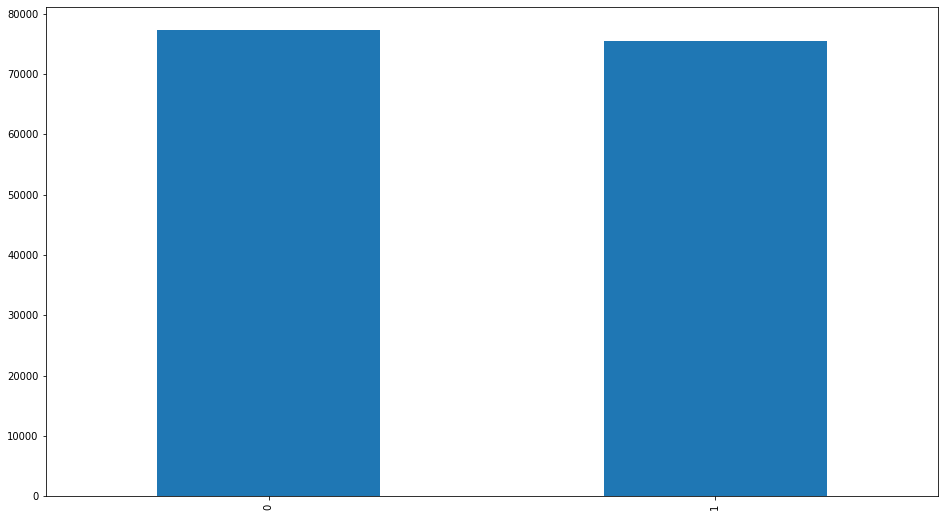

In [18]:
df_dataset['label'].value_counts().plot.bar();

## Text length distribution

In [19]:
df_dataset['sent_len'] = df_dataset['text'].apply(lambda x: len(x.split(" ")))
max_seq_len = np.round(df_dataset['sent_len'].mean() + 2 * df_dataset['sent_len'].std()).astype(int)
max_seq_len

30

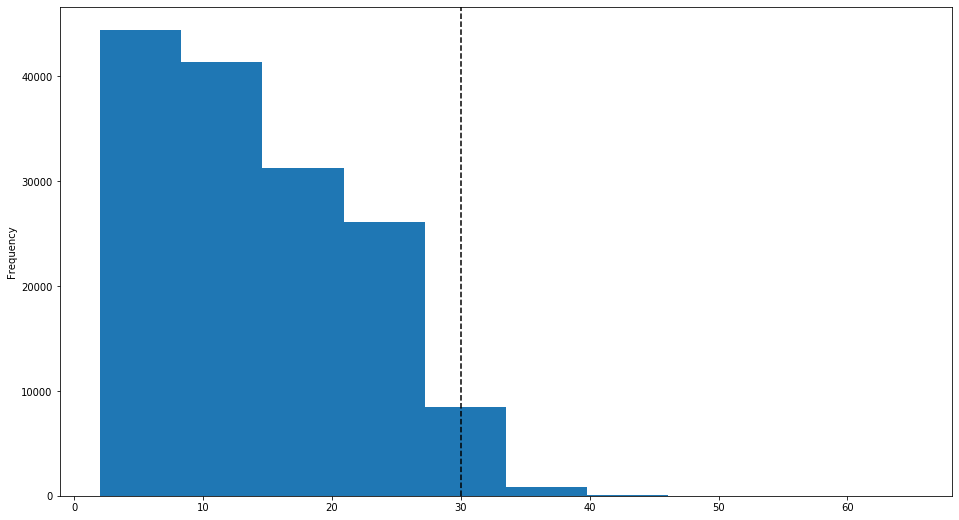

In [20]:
df_dataset['sent_len'].plot.hist()
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len');

## Load fastText word vectors

In [23]:
word_vectors = {}
f = io.open("/content/cc.fr.300.vec", encoding='utf-8')
n, d = map(int, f.readline().split())
for line in tqdm_notebook(f):
    values = line.rstrip().split(' ')
    word = values[0]
    vector = np.array(values[1:], dtype='float32')
    word_vectors[word] = vector
f.close()
print(f'found {len(word_vectors)} word vectors')


found 2000000 word vectors


## Pre-processing

### Clean

In [24]:
df_dataset.head()

,label,text,sent_len
471040,0,El som et la société humaine avec cindy! Je ve...,16
1340507,1,Quel beau jour d'été,4
757669,0,Déteste assis à l'intérieur quand c'est une be...,9
119639,0,Lundi matin même pas le soleil,6
1190949,1,La soeur a juste été bronzée: soph: 'what are ...,23


In [0]:
regex_tokenizer = RegexpTokenizer(r'\w+')

In [27]:
cleaned_text = []

for text in tqdm_notebook(df_dataset['text']):
    tokens = regex_tokenizer.tokenize(text)
    cleaned_text.append(" ".join(tokens))

In [28]:
print(cleaned_text[0])

El som et la société humaine avec cindy Je veux vraiment un chiot ou un chaton


### Tokenize

In [0]:
max_words = 1e5

In [0]:
tokenizer = Tokenizer(num_words=max_words, lower=True, char_level=False)

In [104]:
tokenizer.fit_on_texts(cleaned_text)
input_sequences = tokenizer.texts_to_sequences(cleaned_text)

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  66923


In [105]:
print(input_sequences[0])

[3530, 15084, 9, 5, 2152, 6488, 33, 8818, 1, 77, 58, 11, 1173, 109, 11, 2811]


### Padding

In [0]:
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len)

In [107]:
print(input_sequences[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0  3530 15084     9     5  2152  6488    33  8818     1    77
    58    11  1173   109    11  2811]


In [0]:
labels = df_dataset['label'].values

In [109]:
print(labels[0])

0


## Embedding matrix

In [0]:
embed_dim = 300

In [111]:
words_not_found = []
nb_words = min(max_words, len(word_index))

embedding_matrix = np.zeros((nb_words+1, embed_dim))

for word, i in word_index.items():
    if i > nb_words:
        break

    vector = word_vectors.get(word)
    if vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = vector
    else:
        words_not_found.append(word)

print('number of null word embeddings: {:d}'.format(np.sum(np.sum(embedding_matrix, axis=1) == 0)))

number of null word embeddings: 24344


In [112]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['avvo' 'shizzzz' 'bessee' 'mleh' 'microsciper' 'chillaxing' 'mallows'
 'traci' 'peaple' 'linkety']


## Train Test Split

In [0]:
X_train, X_test, y_train, y_test = (
    train_test_split(input_sequences, labels, random_state=42, test_size=0.2)
)

In [0]:
X_train = tf.constant(X_train)
X_test = tf.constant(X_test)

y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

In [115]:
print(f'Train | X shape: {X_train.shape}, y shape: {y_train.shape}')
print(f'Test | X shape: {X_test.shape}, y shape: {y_test.shape}')

Train | X shape: (122137, 30), y shape: (122137,)
Test | X shape: (30535, 30), y shape: (30535,)


## Create model

In [0]:
def create_model(input_len):
    inp = Input(shape=(input_len,))

    x = Embedding(nb_words+1, embed_dim,
                  weights=[embedding_matrix],
                  input_length=input_len, trainable=False)(inp)
    
    x1 = Conv1D(200, 3, activation='relu', padding='same')(x)
    x1 = GlobalMaxPooling1D()(x1)

    x2 = Conv1D(200, 4, activation='relu', padding='same')(x)
    x2 = GlobalMaxPooling1D()(x2)

    x3 = Conv1D(200, 5, activation='relu', padding='same')(x)
    x3 = GlobalMaxPooling1D()(x3)

    x = concatenate([x1, x2, x3])
    x = Dropout(0.5)(x)
    x = Dense(30, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=x)

    opt = tf.keras.optimizers.Adam(lr=0.001)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [117]:
model = create_model(max_seq_len)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 300)      20077200    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 30, 200)      180200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 30, 200)      240200      embedding_1[0][0]                
____________________________________________________________________________________________

## Training

In [118]:
loss, metric = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
print(f"Loss before training: {loss:.4f}, Accuracy before training: {metric:.2%}")

Loss before training: 0.6909, Accuracy before training: 51.53%


In [119]:
history = model.fit(X_train, y_train, batch_size=256, epochs=5, validation_data=(X_test, y_test))

Train on 122137 samples, validate on 30535 samples
Epoch 1/5
122137/122137 [==============================] - 10s 84us/sample - loss: 0.6055 - accuracy: 0.6668 - val_loss: 0.5322 - val_accuracy: 0.7356
Epoch 2/5
122137/122137 [==============================] - 10s 79us/sample - loss: 0.5276 - accuracy: 0.7415 - val_loss: 0.5027 - val_accuracy: 0.7575
Epoch 3/5
122137/122137 [==============================] - 10s 78us/sample - loss: 0.5025 - accuracy: 0.7595 - val_loss: 0.4855 - val_accuracy: 0.7689
Epoch 4/5
122137/122137 [==============================] - 9s 78us/sample - loss: 0.4873 - accuracy: 0.7691 - val_loss: 0.4758 - val_accuracy: 0.7732
Epoch 5/5
122137/122137 [==============================] - 10s 80us/sample - loss: 0.4753 - accuracy: 0.7765 - val_loss: 0.4774 - val_accuracy: 0.7745


## Test model on new sentences

In [0]:
def predict(text):
  # pre-process text
    tokens = regex_tokenizer.tokenize(text)
    cleaned_text = [" ".join(tokens)]
    
    input_ = tokenizer.texts_to_sequences(cleaned_text)
    input_ = pad_sequences(input_, maxlen=max_seq_len)
    
    pred = model.predict(input_)[0]

    return pred

In [0]:
text = "Vive la vie lol"

In [158]:
predict(text)

array([0.87678874], dtype=float32)

In [0]:
text = "Je n'aime pas faire la vaisselle"

In [133]:
predict(text)

array([0.26208484], dtype=float32)